# Project 2. Wildfires

# Introduction

*I was born and raised in California and never experienced a life-threatening wildfire while growing up. However, two major fires have threatened my hometown in the last three years.The first was the Tubbs fire in 2017 that didn’t actually hit my hometown, but did hit both surrounding cities. Many people that I had grown up with lost their homes. Then, this October there was the Kincade Fire that was so close to my home that it burned the regional park just down the street. Since wildfires are now more personal and relevant to me, I'd like to see if I could use what I’ve learned in my data science class to predict the causes of these wildfires and answer the following: what is the most determining factor when predicting the causes? Additionally, since UT has become a second home to me I thought it’d be fun to compare the two states.*

# Gather Data

*Read in necessary libraries*

In [242]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split, cross_val_score

*To get the data file, follow the link https://www.kaggle.com/rtatman/188-million-us-wildfires and click 'Download (759 MB).' This will download a zip folder onto your local machine. Once you extract all from the zip folder, you will see the file 'FPA_FOD_20170508.sqlite' which contains all the data you'll need. The kaggle page gives an outline of how the data is stored (i.e. what each column stores). The file is too big to upload to a GitHub repository.*

In [3]:
# wildfires that occurred in the United States from 1992 to 2015
cnx = sqlite3.connect('FPA_FOD_20170508.sqlite')

*Chose variables based on what you think is most impactful in determining cause, or variables you are interested in for EDA*

In [64]:
# Descriptions of variables found under 'Content' section (right under 'Context' section) on kaggle link
df = pd.read_sql_query("SELECT FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,COUNTY FROM 'Fires'", cnx)

In [65]:
print(df.head())

   FIRE_YEAR  DISCOVERY_DATE STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  \
0       2005       2453403.5    Miscellaneous  40.036944 -121.005833    CA   
1       2004       2453137.5        Lightning  38.933056 -120.404444    CA   
2       2004       2453156.5   Debris Burning  38.984167 -120.735556    CA   
3       2004       2453184.5        Lightning  38.559167 -119.913333    CA   
4       2004       2453184.5        Lightning  38.559167 -119.933056    CA   

  COUNTY  
0     63  
1     61  
2     17  
3      3  
4      3  


In [66]:
# DISCOVERY_DATE field in Julian Date format
# convert this field to Gregorian dates (the date format we use everyday) 
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_MONTH'] = pd.DatetimeIndex(df['DATE']).day
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday_name
print(df.head())

   FIRE_YEAR  DISCOVERY_DATE STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  \
0       2005       2453403.5    Miscellaneous  40.036944 -121.005833    CA   
1       2004       2453137.5        Lightning  38.933056 -120.404444    CA   
2       2004       2453156.5   Debris Burning  38.984167 -120.735556    CA   
3       2004       2453184.5        Lightning  38.559167 -119.913333    CA   
4       2004       2453184.5        Lightning  38.559167 -119.933056    CA   

  COUNTY       DATE  MONTH  DAY_OF_MONTH DAY_OF_WEEK  
0     63 2005-02-02      2             2   Wednesday  
1     61 2004-05-12      5            12   Wednesday  
2     17 2004-05-31      5            31      Monday  
3      3 2004-06-28      6            28      Monday  
4      3 2004-06-28      6            28      Monday  


In [78]:
df.head().to_csv('head.csv', index=False)

In [76]:
# don't actually need date anymore since broke it up into different variables
df1 = df.drop('DISCOVERY_DATE',axis=1)
df1 = df1.drop('DATE',axis=1)
print(df1.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE COUNTY  MONTH  \
0       2005    Miscellaneous  40.036944 -121.005833    CA     63      2   
1       2004        Lightning  38.933056 -120.404444    CA     61      5   
2       2004   Debris Burning  38.984167 -120.735556    CA     17      5   
3       2004        Lightning  38.559167 -119.913333    CA      3      6   
4       2004        Lightning  38.559167 -119.933056    CA      3      6   

   DAY_OF_MONTH DAY_OF_WEEK  
0             2   Wednesday  
1            12   Wednesday  
2            31      Monday  
3            28      Monday  
4            28      Monday  


### EDA

*Subset data to compare fires in CA (home state) and UT (state currently live in)*

In [202]:
df_CA = df1[df1['STATE']=='CA']
df_UT = df1[df1['STATE']=='UT']

*Add Tubbs fire data*

In [203]:
# Data from Wikipedia
df_Tubbs = pd.DataFrame([[2017,'Powerline',38.60895,-122.62879, 'CA','Sonoma',10,8,'Sunday']], columns=list(df_CA.columns))
df_CA=df_CA.append(df_Tubbs)

In [197]:
df_CA.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,COUNTY,MONTH,DAY_OF_MONTH,DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,63,2,2,Wednesday
1,2004,Lightning,38.933056,-120.404444,CA,61,5,12,Wednesday
2,2004,Debris Burning,38.984167,-120.735556,CA,17,5,31,Monday
3,2004,Lightning,38.559167,-119.913333,CA,3,6,28,Monday
4,2004,Lightning,38.559167,-119.933056,CA,3,6,28,Monday


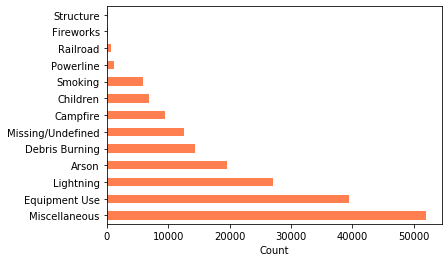

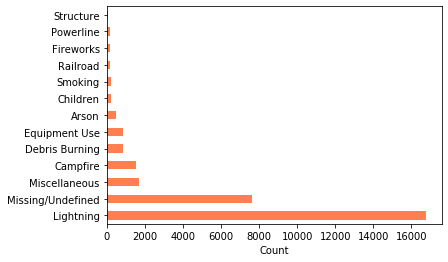

In [136]:
df_CA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.xlabel('Count')
plt.show()
df_UT['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.xlabel('Count')
plt.show()

*Look at causes specifically in my county*

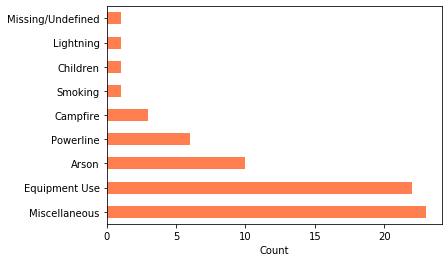

In [137]:
df_CA['STAT_CAUSE_DESCR'][df_CA.COUNTY=='Sonoma'].value_counts().plot(kind='barh',color='coral')
plt.xlabel('Count')
plt.show()

*Look at distribution for some of variables, like Day of the Week*

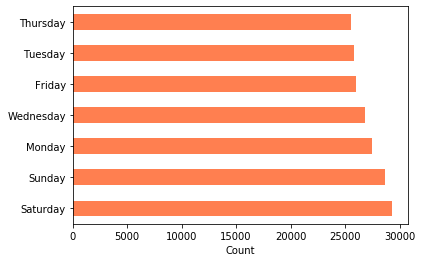

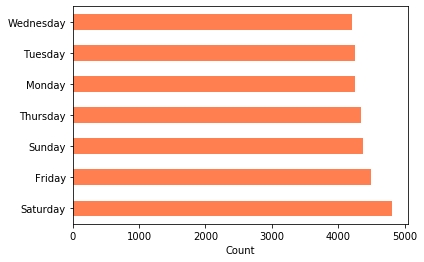

In [138]:
df_CA['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.xlabel('Count')
plt.show()
# appears to be slightly more on weekends
df_UT['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.xlabel('Count')
plt.show()

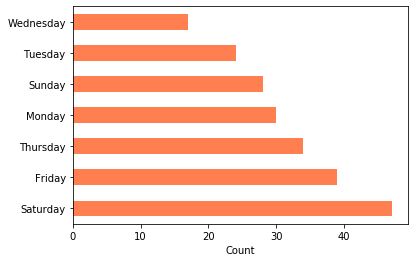

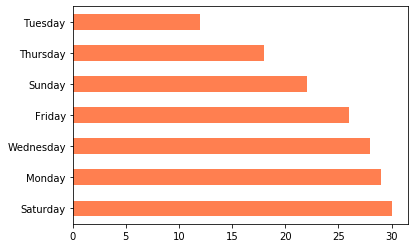

In [112]:
df_fireworks = df_CA[df_CA['STAT_CAUSE_DESCR']=='Fireworks']
df_fireworks['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.xlabel('Count')
plt.show()
df_fireworks = df_UT[df_UT['STAT_CAUSE_DESCR']=='Fireworks']
df_fireworks['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

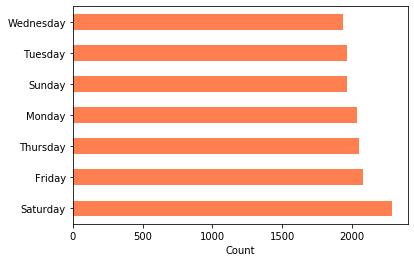

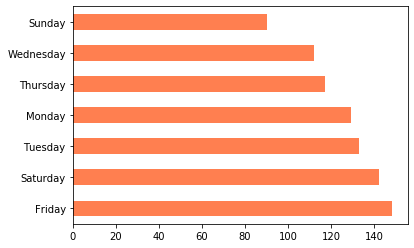

In [139]:
# try with more prevalent cause
df_debris = df_CA[df_CA['STAT_CAUSE_DESCR']=='Debris Burning']
df_debris['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.xlabel('Count')
plt.show()
df_debris = df_UT[df_UT['STAT_CAUSE_DESCR']=='Debris Burning']
df_debris['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

*Clearly, day of the week seems like a good variable to include*

*Get some idea about the geographical coverage of the data by plotting each latitude and longitude pair*

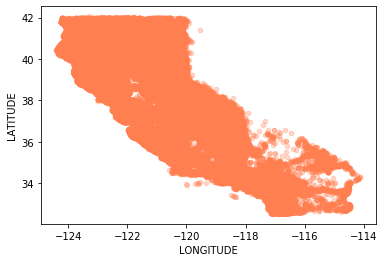

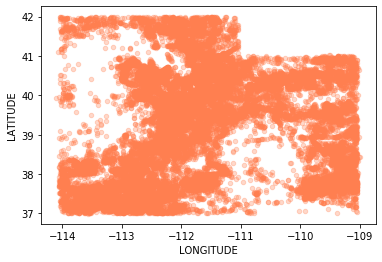

In [140]:
df_CA.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='coral',alpha=0.3)
plt.show()
df_UT.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='coral',alpha=0.3)
plt.show()

*Reduce number of classes*

In [204]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause  

df_CA['LABEL'] = df_CA['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) 
df_UT['LABEL'] = df_UT['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))

C:\Users\savani\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [205]:
le = preprocessing.LabelEncoder()
df_CA['STAT_CAUSE_DESCR'] = le.fit_transform(df_CA['STAT_CAUSE_DESCR'])
df_CA['STATE'] = le.fit_transform(df_CA['STATE'])
df_CA['DAY_OF_WEEK'] = le.fit_transform(df_CA['DAY_OF_WEEK'])
print(df_CA.head())
df_UT['STAT_CAUSE_DESCR'] = le.fit_transform(df_UT['STAT_CAUSE_DESCR'])
df_UT['STATE'] = le.fit_transform(df_UT['STATE'])
df_UT['DAY_OF_WEEK'] = le.fit_transform(df_UT['DAY_OF_WEEK'])
print(df_UT.head())

   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE COUNTY  MONTH  \
0       2005                 7  40.036944 -121.005833      0     63      2   
1       2004                 6  38.933056 -120.404444      0     61      5   
2       2004                 3  38.984167 -120.735556      0     17      5   
3       2004                 6  38.559167 -119.913333      0      3      6   
4       2004                 6  38.559167 -119.933056      0      3      6   

   DAY_OF_MONTH  DAY_OF_WEEK  LABEL  
0             2            6      4  
1            12            6      1  
2            31            1      2  
3            28            1      1  
4            28            1      1  
     FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE COUNTY  MONTH  \
63        2005                 6  40.088889 -111.378333      0     49      6   
195       2005                11  41.264167 -111.795833      0     57      7   
592       2005                 6  41.258333 -111.849722      0 

C:\Users\savani\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\savani\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\savani\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

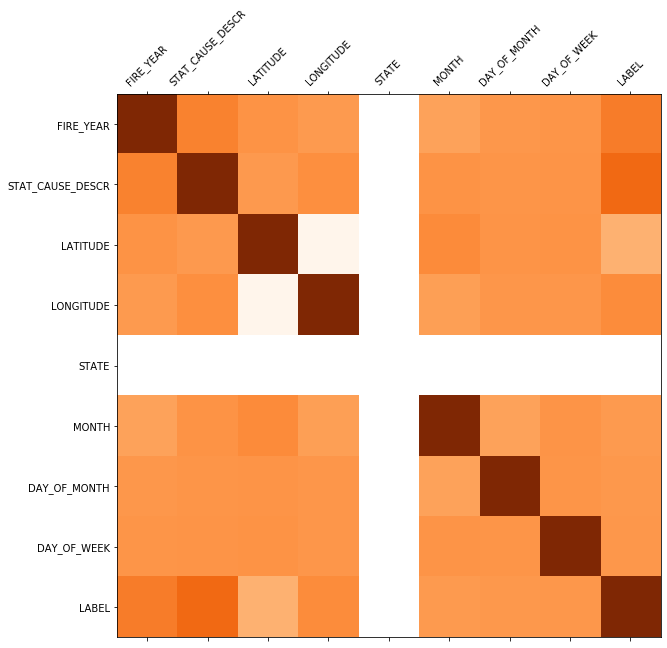

In [206]:
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()

plot_corr(df_CA)

# Methods

In [208]:
df_CA = df_CA.dropna()
df_UT = df_UT.dropna()

In [209]:
X1 = df_CA[['FIRE_YEAR','LATITUDE','LONGITUDE','MONTH','DAY_OF_MONTH','DAY_OF_WEEK']]
X2 = df_UT[['FIRE_YEAR','LATITUDE','LONGITUDE','MONTH','DAY_OF_MONTH','DAY_OF_WEEK']]
y1 = df_CA[['LABEL']]
y2 = df_UT[['LABEL']]

In [210]:
df_CA.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,COUNTY,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,LABEL
0,2005,7,40.036944,-121.005833,0,63,2,2,6,4
1,2004,6,38.933056,-120.404444,0,61,5,12,6,1
2,2004,3,38.984167,-120.735556,0,17,5,31,1,2
3,2004,6,38.559167,-119.913333,0,3,6,28,1,1
4,2004,6,38.559167,-119.933056,0,3,6,28,1,1


In [211]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1, random_state=214243, test_size=.30, stratify=y1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, random_state=214243, test_size=.30, stratify=y2)

In [212]:
df_CA.groupby('LABEL')['LABEL'].count()

LABEL
1     9489
2    18749
3     4799
4    23185
Name: LABEL, dtype: int64

In [213]:
df_UT.groupby('LABEL')['LABEL'].count()

LABEL
1    10649
2     2567
3      211
4     8780
Name: LABEL, dtype: int64

*Because there is an imbalance of classes, we will be using the F1 score and accuracy (classification report) primarily to choose a model. We will not be using roc since that is a measurement for a binary target and we have a multiclass response.*

In [249]:
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn import metrics

### Random Forest

*Reason to use: Can handle multi-class, common/well-known*

In [226]:
from sklearn.ensemble import RandomForestClassifier

In [258]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train1, y_train1)
rf_pred = rf.predict(X_test1)
rf_prob = nb.predict_proba(X_test1)[:,1]
print(metrics.classification_report(y_test1, rf_pred))

C:\Users\savani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           1       0.82      0.85      0.83      2847
           2       0.52      0.50      0.51      5625
           3       0.47      0.21      0.29      1440
           4       0.59      0.67      0.63      6955

    accuracy                           0.60     16867
   macro avg       0.60      0.55      0.56     16867
weighted avg       0.59      0.60      0.59     16867



In [259]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train2, y_train2)
rf_pred = rf.predict(X_test2)
rf_prob = nb.predict_proba(X_test2)[:,1]
print(metrics.classification_report(y_test2, rf_pred))

C:\Users\savani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           1       0.78      0.88      0.83      3195
           2       0.62      0.41      0.50       770
           3       0.78      0.11      0.19        63
           4       0.79      0.75      0.77      2635

    accuracy                           0.77      6663
   macro avg       0.74      0.54      0.57      6663
weighted avg       0.76      0.77      0.76      6663



### Naive Bayes

*Reason to use: Can handle multi-class (also good with data with high dimensionality), also in my past assignments it's performed well despite it's naive assumptions*

In [227]:
from sklearn.naive_bayes import GaussianNB

In [256]:
nb = GaussianNB()
nb.fit(X_train1, y_train1)
y_hat = nb.predict(X_test1)
y_prob = nb.predict_proba(X_test1)[:,1]
print('F1 Score:', metrics.f1_score(y_test1, y_hat, average='macro'))
print(classification_report(y_test1, y_hat))

F1 Score: 0.34351932036428345
              precision    recall  f1-score   support

           1       0.41      0.59      0.48      2847
           2       0.45      0.23      0.30      5625
           3       0.00      0.00      0.00      1440
           4       0.50      0.71      0.59      6955

    accuracy                           0.47     16867
   macro avg       0.34      0.38      0.34     16867
weighted avg       0.43      0.47      0.43     16867



C:\Users\savani\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [260]:
nb = GaussianNB()
nb.fit(X_train2, y_train2)
y_hat = nb.predict(X_test2)
y_prob = nb.predict_proba(X_test2)[:,1]
print('F1 Score:', metrics.f1_score(y_test2, y_hat, average='macro'))
print(classification_report(y_test2, y_hat))

F1 Score: 0.4340996470287693
              precision    recall  f1-score   support

           1       0.66      0.79      0.72      3195
           2       0.52      0.31      0.38       770
           3       0.00      0.00      0.00        63
           4       0.67      0.60      0.63      2635

    accuracy                           0.65      6663
   macro avg       0.46      0.42      0.43      6663
weighted avg       0.64      0.65      0.64      6663



C:\Users\savani\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### KNN

*Can handle multiclass data*

In [240]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

In [243]:
n_neighbors = np.arange(1,50)
k_score = []
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    k_score.append(cross_val_score(knn, X_train1, y_train1, cv=10).mean())
n = n_neighbors[np.argmax(k_score)]
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(X_train1, y_train1)
y_hat_knn = knn.predict(X_test1)
y_prob_knn = knn.predict_proba(X_test1)[:,1]

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

In [261]:
print('F1 Score:', metrics.f1_score(y_test1, y_hat_knn,average='micro'))
print(classification_report(y_test1, y_hat_knn))

F1 Score: 0.5402857651034565
              precision    recall  f1-score   support

           1       0.65      0.76      0.70      2847
           2       0.46      0.41      0.43      5625
           3       0.39      0.06      0.10      1440
           4       0.55      0.66      0.60      6955

    accuracy                           0.54     16867
   macro avg       0.51      0.47      0.46     16867
weighted avg       0.52      0.54      0.52     16867



In [262]:
n_neighbors = np.arange(1,50)
k_score = []
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    k_score.append(cross_val_score(knn, X_train2, y_train2, cv=10).mean())
n = n_neighbors[np.argmax(k_score)]
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(X_train2, y_train2)
y_hat_knn = knn.predict(X_test2)
y_prob_knn = knn.predict_proba(X_test2)[:,1]
print('F1 Score:', metrics.f1_score(y_test2, y_hat_knn,average='micro'))
print(classification_report(y_test2, y_hat_knn))

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\savani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vect

F1 Score: 0.680024013207264
              precision    recall  f1-score   support

           1       0.67      0.85      0.75      3195
           2       0.57      0.29      0.38       770
           3       0.00      0.00      0.00        63
           4       0.72      0.60      0.65      2635

    accuracy                           0.68      6663
   macro avg       0.49      0.44      0.45      6663
weighted avg       0.67      0.68      0.66      6663



C:\Users\savani\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Results

*As stated above, we used the F1 score and accuracy (classification report) primarily to choose a model due to the class imabalance. For both California and Utah, Random Forest had the best overall f1 and accuracy scores (60% accuracy for CA and 77% for UT).*

In [265]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train1, y_train1)
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, 
                         index=X_train1.columns)
Importance = Importance.iloc[rf.feature_importances_> 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=False)

C:\Users\savani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [266]:
Importance.head()

,Importance
LATITUDE,29.330727
LONGITUDE,26.400185
DAY_OF_MONTH,14.735245
FIRE_YEAR,11.362625
MONTH,9.375044


In [267]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train2, y_train2)
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, 
                         index=X_train1.columns)
Importance = Importance.iloc[rf.feature_importances_> 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=False)

C:\Users\savani\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [268]:
Importance.head()

,Importance
LATITUDE,25.254898
LONGITUDE,24.250347
FIRE_YEAR,24.120976
DAY_OF_MONTH,10.718850
MONTH,9.078318


*Most important features for both are Latitude and Longitude*

*Now predict cause of Kincade Fire*

In [275]:
# data information taken from Wikipedia
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train1, y_train1)
rf.predict(pd.DataFrame([[2019,38.792458,-122.780053,10,23,6]], columns=list(X_train1.columns)))

C:\Users\savani\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


array([4], dtype=int64)

# Conclusion

*It turns out that location is the most important factor when predicting the cause of a fire (surprise, surprise). In terms of the model, I would be interested to experiment with One-versus-all or One-versus-one strategies that would allow us to extend binary classifiers to multiple classes. I was also disappointed that my model predicted that the cause of the Kincade fire would be "other" (category #4).  While the cause is still not yet confirmed, there are rumors and investigation that it was a PG&E powerline, which was the same cause of the Tubbs fire. However, since the cause is still unconfirmed, it could potentially be deemed as an "Other" (Miscellaneous or Missing/Undefined), in which case our model will have predicted correctly! Time will tell...*